In [43]:
!pip install mediapipe

In [44]:
import cv2
import mediapipe as mp



### Face Mesh

In [33]:
# 얼굴 메시, 그리기 라이브러리

mp_drawing = mp.solutions.drawing_utils   #모듈가져와서 변수에
mp_face_mesh = mp.solutions.face_mesh

# 그리기 설정 (선 두께, 원의 반지름)
drawing_spec= mp_drawing.DrawingSpec(thickness=1, circle_radius=1)

cap = cv2.VideoCapture('images/face3.mp4')

#최소 검출 신뢰도, 최소 추적 신뢰도
with mp_face_mesh.FaceMesh(min_detection_confidence=0.5,
                          min_tracking_confidence=0.5) as face_mesh:
    #비디오가 열렸다면
    while cap.isOpened():
        success, image = cap.read()
        
        if not success:
            print('비디오 읽기 실패')
            cap.release()
            cv2.destroyAllWindows()
            continue
            
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        image.flags.writeable = False
        #얼굴 메시 검출
        results = face_mesh.process(image)
        
        #이미지에 랜드마크 표시
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        #검출된 랜드마크와 랜드마크를 연결하는 선 그리기
        if results.multi_face_landmarks:
            for face_landmarks in results.multi_face_landmarks:
                # 이미지, 얼굴 랜드마크 목록, 연결기능
                # 랜드마크/연결선 그리기 기능
                mp_drawing.draw_landmarks(
                image=image,
                landmark_list=face_landmarks,
                connections=mp_face_mesh.FACEMESH_CONTOURS,
                landmark_drawing_spec=drawing_spec,
                connection_drawing_spec=drawing_spec)
                
        cv2.imshow('Face Mesh Detector', image)
        
        if cv2.waitKey(49) == 49:
            cap.release()
            cv2.destroyAllWindows()
            break
            
cap.release()

### 얼굴, 왼손, 오른손, 동작 검출(스켈레톤 검출)

In [45]:
# 그리기, 다기능(얼굴, 왼손, 오른손, 동작) 추출기 가져오기
mp_drawing = mp.solutions.drawing_utils
mp_holistic = mp.solutions.holistic

# 비디오 캡쳐
cap = cv2.VideoCapture('images/face4.mp4')

drawing_spec1 = mp_drawing.DrawingSpec(thickness=1, color=(0,0,255))
drawing_spec2 = mp_drawing.DrawingSpec(thickness=3, color=(255,0,0))

with mp_holistic.Holistic(min_detection_confidence=0.5,
                         min_tracking_confidence=0.5) as holistic:
    # 비디오가 열렸다면
    while cap.isOpened():
        ret, image = cap.read()
        
        # 비디오가 로딩 안되면
        if not ret:
            print('비디오 읽기 실패')
            cap.release()
            cv2.destroyAllWindows()
            continue
            
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        image.flags.writeable = False
        
        results = holistic.process(image)
        
        # 이미지에 랜드마크 표시(얼굴,왼손,오른손,동작)
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        # 랜드마크를 이어주는 선 그리기
        mp_drawing.draw_landmarks(image, results.pose_landmarks,
                                 mp_holistic.POSE_CONNECTIONS,
                                 landmark_drawing_spec=drawing_spec1,
                                 connection_drawing_spec=drawing_spec2)
        cv2.imshow('Pose Detector', image)
        
        if cv2.waitKey(49) == 49: # 비디오 끄기
            
            cap.release()
            cv2.destroyAllWindows()
            break
    cap.release()

### 자세 분석

In [46]:
import time
import math as m
from PIL import ImageFont, ImageDraw, Image
import numpy as np

In [47]:
# 포즈 분석과 다기능(얼굴, 왼손, 오른손, 동작) 추출기 가져오기
mp_pose = mp.solutions.pose
mp_holistic = mp.solutions.holistic

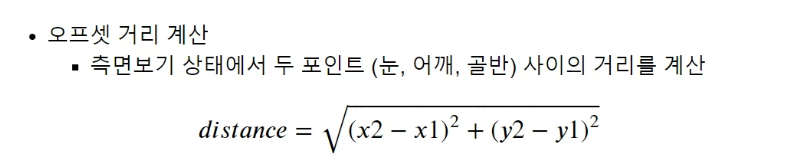

In [48]:
# 거리 계산 함수
def findDistance(x1, y1, x2, y2):
    dist = m.sqrt((x2-x1)**2+(y2-y1)**2)
    return dist


- 관심 선에서 y축으로 종속된 각도 계산
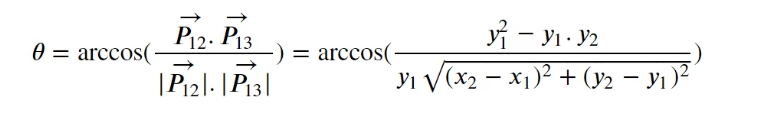

In [49]:
# 각도 계산 함수
def findAngle(x1, y1, x2, y2):
    theta = m.acos((y2-y1)*(-y1) / (m.sqrt((x2-x1)**2+(y2-y1)**2)*y1))
    degree = int(180/m.pi)*theta
    return degree

In [50]:
# 프레임 카운터 초기화
good_frames = 0
bad_frames = 0

# 폰트 설정
font = cv2.FONT_HERSHEY_SIMPLEX

# 색상 설정
blue = (255, 127, 0)
red = (50, 50, 255)
green = (127, 255, 0)
dark_blue = (127, 20, 0)
light_green= (127, 233, 100)
yellow = (0, 255, 255)
pinl = (255, 0, 255)

In [65]:
# mediapipe pose class 초기화
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()

cap = cv2.VideoCapture('images/pose.mp4')

print('Pricessing')

while cap.isOpened():
    success, image = cap.read()
    if not success:
        print('프레임 이미지 없음')
        break
        
    # 초당 프레임 수 가져오기
    fps = cap.get(cv2.CAP_PROP_FPS)
    # 프레임 이미지 크기 가져오기
    h,w = image.shape[:2]
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # 포즈 검출
    keypoits = pose.process(image)
    
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    
    # 대표 랜드마크 저장
    Im = keypoits.pose_landmarks
    ImPose = mp_pose.PoseLandmark
    
    # 랜드마크 좌표 획득
    # 왼쪽 어깨 좌표
    l_shldr_x = int(Im.landmark[ImPose.LEFT_SHOULDER].x*w)
    l_shldr_y = int(Im.landmark[ImPose.LEFT_SHOULDER].y*h)
    
    # 오른쪽 어깨 좌표
    r_shldr_x = int(Im.landmark[ImPose.RIGHT_SHOULDER].x*w)
    r_shldr_y = int(Im.landmark[ImPose.RIGHT_SHOULDER].y*h)
    
    # 왼쪽 귀 좌표
    l_ear_x = int(Im.landmark[ImPose.LEFT_EAR].x*w)
    l_ear_y = int(Im.landmark[ImPose.LEFT_EAR].y*h)
    
    # 왼쪽 골반 좌표
    l_hip_x = int(Im.landmark[ImPose.LEFT_HIP].x*w)
    l_hip_y = int(Im.landmark[ImPose.LEFT_HIP].y*h)
    
    # 왼쪽 어깨점과 오른쪽 어깨점들 간의 거리 계산
    offset = findDistance(l_shldr_x, l_shldr_y, r_shldr_x, r_shldr_y)
    
    # 왼쪽과 오른쪽 어깨점의 차이가 100이하면 offset 값 출력
    if offset < 100:
        cv2.putText(image, str(int(offset))+'Aligned',
                   (w - 150, 30), font, 0.9, green,2)
    else:
        cv2.putText(image, str(int(offset))+'Not Aligned',
                   (w - 150, 30), font, 0.9, red,2)
        
    # 눈-어깨, 어깨-골반 간의 각도 계산
    neck_inclination = findAngle(l_shldr_x, l_shldr_y, l_ear_x, l_ear_y)
    torso_inclination = findAngle(l_hip_x, l_hip_y, l_shldr_x, l_shldr_y)
    
    # 랜드 마크점 - 노란 원으로 그림
    # 왼쪽 어깨
    cv2.circle(image, (l_shldr_x, l_shldr_y), 7, yellow, -1)
    # 왼쪽 귀
    cv2.circle(image, (l_ear_x, l_ear_y), 7, yellow, -1) 
    # 왼쪽 골반
    cv2.circle(image, (l_hip_x, l_hip_y), 7, yellow, -1)  
    
    # 눈-어깨, 어깨-골반 간의 각도 출력
    angle_text_string = 'Neck : ' + str(int(neck_inclination)) + ' Torso : ' + str(int(torso_inclination))
    
    # 눈-어깨의 각도가 40이하, 어깨-골반의 각도가 10 이하인 경우
    # → 좋은 자세로 판별
    if neck_inclination<40 and torso_inclination<10:
        bad_frames = 0
        good_frames += 1
        
        # 각도 출력
        cv2.putText(image, angle_text_string, (10,30),
                   font, 0.9, light_green, 2)
        cv2.putText(image, str(int(neck_inclination)),
                   (l_shldr_x+10, l_shldr_y),
                   font, 0.9, light_green, 2)
        cv2.putText(image, str(int(torso_inclination)),
                   (l_hip_x+10, l_hip_y),
                   font, 0.9, light_green, 2)
        
        # 랜드마크 점을 연결하는 녹색 선 그리기
        # 왼쪽 눈 - 왼쪽 어깨
        cv2.line(image, (l_shldr_x, l_shldr_y), (l_ear_x, l_ear_y), green, 4)
        # 왼쪽 골반 - 왼쪽 어깨
        cv2.line(image, (l_hip_x, l_hip_y), (l_shldr_x, l_shldr_y), green, 4)
        
    else:
        good_frames = 0
        bad_frames += 1

        cv2.putText(image, angle_text_string, (10,30),
                   font, 0.9, red, 2)
        cv2.putText(image, str(int(neck_inclination)),
                   (l_shldr_x+10, l_shldr_y), font, 0.9, red, 2)
        cv2.putText(image, str(int(torso_inclination)),
                   (l_hip_x+10, l_shldr_y), font, 0.9, red, 2)

        cv2.line(image, (l_shldr_x, l_shldr_y),
                (l_ear_x, l_ear_y), red, 4)
        cv2.line(image, (l_hip_x, l_hip_y),
                (l_shldr_x, l_shldr_y), red, 4)
            
        # 특정 자세( 좋은 자세, 나쁜 자세)  유지 시간 계산
        good_time = (1/fps)*good_frames
        bad_time = (1/fps)*bad_frames
        
        # 특정 자세 유지 시간 출력
        if good_time > 0:
            time_str_good = 'Good Time : ' + str(round(good_time,1)) + 's'
            cv2.putText(image, time_str_good, (10,h-20),
                       font, 0.9,green, 2)
        else :
            time_str_bad = 'Bad Time : ' + str(round(bad_time, 1)) + 's'
            cv2.putText(image, time_str_bad, (10, h-20),
                       font, 0.9, red, 2)
            
        cv2.imshow('result', image)
        
        if cv2.waitKey(33) == 49 :
            cap.release()
            cv2.destroyAllWindows()
            break
            
print('Finished.')
cap.release()
cv2.destroyAllWindows()
        
            

Pricessing
Finished.
